In [3]:
import pygraspi
import numpy as np
from pygraspi.combined_descriptors import *
import pandas
import networkx as nx
import sknw
import glob
import os

In [7]:
os.chdir(r'/users/dgj1/Documents/pygraspi/notebooks/data')
myFiles = glob.glob('*.txt')
myFiles.sort()
l = []
for i, file in enumerate(myFiles[0:100]):
    morph = np.array(pandas.read_csv(file, delimiter=' ', header=None)).swapaxes(0, 1)
    l.append(morph)
    



In [ ]:
result = pd.concat([make_descriptors(l), make_graphdescriptors(l)], axis=1, join='inner')

In [8]:
result

,branch_length_a,branch_length_b,dist_to_interface_avg_a,dist_to_interface_avg_b,dist_to_interface_max_a,dist_to_interface_max_b,dist_to_interface_min_a,dist_to_interface_min_b,f_skeletal_pixels_a,f_skeletal_pixels_b,...,number_of_intersections_a,number_of_intersections_b,distance_to_interface,interfacial_area,phase_0_cc,phase_0_count,phase_0_interface,phase_1_cc,phase_1_count,phase_1_interface
0,44.71,39.28,9.25,9.50,15.000000,20.591260,1.000000,1.000000,0.03,0.02,...,11,5,5.459273,5426,15,19600,2697,7,20901,2729
1,46.08,33.81,9.63,10.36,16.124515,20.808652,1.000000,1.000000,0.03,0.02,...,12,5,5.760697,5082,16,19341,2518,5,21160,2564
2,42.78,32.97,10.72,11.79,17.691806,21.587033,4.000000,1.000000,0.03,0.02,...,13,3,6.261401,4508,15,19233,2230,4,21268,2278
3,41.83,34.24,11.29,11.90,18.867962,20.880613,6.000000,1.000000,0.02,0.02,...,11,4,6.427940,4340,14,19334,2150,5,21167,2190
4,48.43,37.25,11.40,12.66,18.973666,21.000000,1.000000,1.000000,0.03,0.01,...,10,2,6.624182,4166,14,19293,2062,4,21208,2104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,53.27,53.07,14.57,15.15,25.961510,29.832868,1.000000,1.000000,0.02,0.02,...,5,3,7.843708,3406,9,19723,1697,6,20778,1709
96,56.02,60.13,15.53,16.03,25.495098,30.000000,1.000000,1.000000,0.02,0.01,...,4,3,8.193798,3200,8,19716,1596,6,20785,1604
97,71.00,52.23,24.27,25.60,39.924930,50.635956,1.000000,7.615773,0.01,0.01,...,2,1,12.572356,2006,5,19663,1000,4,20838,1006
98,78.37,58.65,24.99,25.57,40.804412,50.990195,10.049876,1.000000,0.01,0.01,...,2,1,12.808894,1956,5,19651,975,4,20850,981


In [30]:
train, test = train_test_split(result, test_size=0.2)

In [11]:
import dask.array as da
from dask.distributed import Client
from dask_ml.preprocessing import MinMaxScaler
from dask_ml.linear_model import LogisticRegression
from dask_ml.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import confusion_matrix
from toolz.curried import pipe, curry

from pymks import (
    solve_cahn_hilliard,
    plot_microstructures,
    graph_descriptors,
    GenericTransformer,
    GraphDescriptors
)

In [12]:
Client()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 62.74 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33399,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 62.74 GiB
Comm: tcp://127.0.0.1:41931,Total threads: 3
Dashboard: http://127.0.0.1:34007/status,Memory: 15.68 GiB
Nanny: tcp://127.0.0.1:34297,


In [13]:
da.random.seed(99)

n_sample = 144
n_domain = 101
n_chunks = 24

x_data = (
    2 * da.random.random((n_sample, n_domain, n_domain), chunks=(n_chunks, n_domain, n_domain)) - 1
)
y_data = solve_cahn_hilliard(x_data, delta_t=1.0, n_steps=100, delta_x=0.5).persist()

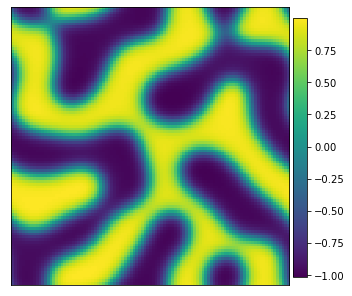

In [14]:
plot_microstructures(y_data[0])

In [27]:
y_data_binned = da.where(y_data > 0, 1, 0).persist()
y_data_np = y_data_binned.compute()

In [33]:
#NBVAL_SKIP

#%time out_pandas = pd.concat([make_descriptors(y_data_np), make_graphdescriptors(y_data_np)], axis=1, join='inner')

In [31]:
def generate_data(n_category, n_chunks, n_domain, seed=99):
    da.random.seed(seed)
    solve_ch = curry(solve_cahn_hilliard)(delta_t=1.0, delta_x=0.5)
    x_data = pipe(
        da.random.random((n_category * 2, n_domain, n_domain),
                         chunks=(n_chunks, n_domain, n_domain)),
        lambda x: 2 * x - 1,
        lambda x: [
            solve_ch(x[:n_category], n_steps=10),
            solve_ch(x[n_category:], n_steps=100)
        ],
        da.concatenate,
        lambda x: da.where(x > 0, 1, 0).persist()
    )
    y_data = da.from_array(
        np.concatenate([np.zeros(n_category), np.ones(n_category)]).astype(int),
        chunks=(n_chunks,)
    )
    return x_data, y_data

In [32]:
n_category = 96
n_chunks = 24
n_domain = 101

x_data, y_data = generate_data(n_category, n_chunks, n_domain)

In [35]:
make_descriptors(x_data)

,branch_length_a,branch_length_b,dist_to_interface_avg_a,dist_to_interface_avg_b,dist_to_interface_max_a,dist_to_interface_max_b,dist_to_interface_min_a,dist_to_interface_min_b,f_skeletal_pixels_a,f_skeletal_pixels_b,number_of_branches_a,number_of_branches_b,number_of_ends_a,number_of_ends_b,number_of_intersections_a,number_of_intersections_b
0,12.81,16.22,4.09,4.14,8.485281,9.433981,1.0,1.0,0.07,0.06,62.0,40.0,34,34,26,14
1,15.53,18.43,4.17,4.68,8.000000,17.888544,1.0,1.0,0.06,0.07,41.0,42.0,33,27,13,17
2,15.63,17.95,4.16,4.48,7.810250,11.661904,1.0,1.0,0.06,0.07,44.0,43.0,33,30,17,18
3,13.42,16.09,4.08,4.22,11.313708,9.000000,1.0,1.0,0.08,0.05,65.0,40.0,35,40,27,10
4,13.00,13.48,4.10,4.35,8.944272,9.433981,1.0,1.0,0.06,0.06,56.0,55.0,39,39,22,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,24.75,26.36,6.87,6.15,11.180340,13.341664,1.0,1.0,0.03,0.05,14.0,22.0,19,14,3,10
188,54.66,36.32,6.65,6.62,13.000000,15.000000,1.0,1.0,0.04,0.05,8.0,14.0,10,13,2,5
189,28.36,24.15,6.32,6.93,12.041595,15.524175,1.0,1.0,0.04,0.04,15.0,13.0,11,19,5,1
190,26.23,25.41,6.57,6.61,10.770330,14.142136,1.0,1.0,0.04,0.04,17.0,14.0,16,15,6,3


In [37]:
#pd.concat([make_descriptors(x_data), make_graphdescriptors(x_data)], axis=1, join='inner')
x_train, x_test, y_train, y_test = train_test_split(
    x_data.reshape(x_data.shape[0], -1),
    y_data,
    test_size=0.2
)

In [40]:
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x_train)

In [42]:
clf = LogisticRegression(random_state=0).fit(x_scaled, y_train)

/nix/store/9m671gxr447kdmyc2y3jbg7hnyi9czcy-python3.9-dask-glm-0.2.0/lib/python3.9/site-packages/dask_glm/utils.py:52: RuntimeWarning: overflow encountered in exp
  return np.exp(A)
/nix/store/9m671gxr447kdmyc2y3jbg7hnyi9czcy-python3.9-dask-glm-0.2.0/lib/python3.9/site-packages/dask_glm/utils.py:52: RuntimeWarning: overflow encountered in exp
  return np.exp(A)
/nix/store/9m671gxr447kdmyc2y3jbg7hnyi9czcy-python3.9-dask-glm-0.2.0/lib/python3.9/site-packages/dask_glm/utils.py:52: RuntimeWarning: overflow encountered in exp
  return np.exp(A)
/nix/store/9m671gxr447kdmyc2y3jbg7hnyi9czcy-python3.9-dask-glm-0.2.0/lib/python3.9/site-packages/dask_glm/utils.py:52: RuntimeWarning: overflow encountered in exp
  return np.exp(A)


In [46]:
y_predict = clf.predict(x_test)

In [47]:
confusion_matrix(y_test.compute(), y_predict.compute())

array([[ 7, 13],
       [10, 10]])